# Exploratory Data Analysis

Load libraries used in this notebook.

In [44]:
'''IMPORT LIBRARIES'''

import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor 
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.figsize'] = (13.0, 6.0)

# Aesthetic settings
from IPython.display import display
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 500)
sns.set_style('whitegrid')
sns.set_context('talk')
from matplotlib.backends.backend_pdf import PdfPages

import pickle

## Data Loading and Cleaning

The data used for the project comes from the Alzheimer's Disease Neuroimaging Initiative (ADNI) database. For the exploratory data analysis (EDA), we have decided to explore the database $\texttt{ADNIMERGE.csv}$ which contains the studies ADNI1, ADNIGO, and ADNI2.

To navigate through the $\texttt{ADNIMERGE}$ database and analyse the data, we implement the following functions. 

In [45]:
'''DATABASE NAVIGATION FUNCTIONS'''

def read_df(file_name):
    ''' 
    **Read in csv file and return pandas dataframe
    * param[in] file_name string of the file name with extension csv
    * param[out] df pandas dataframe
    '''
    df = pd.read_csv(file_name)
    return df

def dict_df(file_name):
    ''' 
    **Make dictionnary of predictors based on csv file
    * param[in] file_name string of dictionnary csv
    * param[out] df pandas dataframe linking predictor to its definition
    '''
    toKeep = ['FLDNAME','TEXT','NOTES']
    df= pd.read_csv(file_name)
    drop_col = df.columns.difference(toKeep)
    df = df.drop(drop_col,axis=1)
    return df

def get_dict_def(p,df_dict):
    ''' 
    **Ask for the definition of a predictor
    * param[in] p string predictor field name
    * param[in] df_dict pandas dataframe linking predictor to its definition
    * param[out] text string definition of the predictior
    * param[out] notes string notes on the predictor
    '''
    row = df_dict[df_dict['FLDNAME'].str.match(p)]
    if row.empty:
        text =  'field name not in DF'
        notes = 'field name not in DF'
        return text,notes
    text = row['TEXT'].values[0]
    notes = row['NOTES'].values[0]
    return text,notes

Let us try to make sense of the different files accessible on the Alzheimer's Disease Neuroimaging Initiative (ADNI). The different studies are entitled ADNI1, ADNIGO, and ADNI2. The dataset ANDIMERGE merges a lot of usefull information from the $3$ studies. Let us take a look.

In [46]:
'''READ AND LOAD DATABASE'''

#Read in the db
f = 'ADNIDataFiles/ADNIMERGE.csv'
df = read_df(f)

#Print only the first few rows and columns
row_print = 5
col_print = 14
print('First rows and columns of the dataframe')
display(df.loc[0:row_print,df.columns[0:col_print]])

First rows and columns of the dataframe


,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY
0,2,011_S_0002,bl,11,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,16,Not Hisp/Latino,White,Married
1,3,011_S_0003,bl,11,ADNI1,ADNI1,2005-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married
2,3,011_S_0003,m06,11,ADNI1,ADNI1,2006-03-13,AD,81.3,Male,18,Not Hisp/Latino,White,Married
3,3,011_S_0003,m12,11,ADNI1,ADNI1,2006-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married
4,3,011_S_0003,m24,11,ADNI1,ADNI1,2007-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married
5,4,022_S_0004,bl,22,ADNI1,ADNI1,2005-11-08,LMCI,67.5,Male,10,Hisp/Latino,White,Married


First, let us take a look at the columns. Let us see how many we have and what are their names.

In [47]:
'''COLUMNS OF THE DF'''

#Count and display columns
n_col = df.shape[1]
col   = df.columns.values
print('The data frame contains',n_col,'columns.')
print('The different columns name are:')
print(col)

The data frame contains 94 columns.
The different columns name are:
['RID' 'PTID' 'VISCODE' 'SITE' 'COLPROT' 'ORIGPROT' 'EXAMDATE' 'DX_bl'
 'AGE' 'PTGENDER' 'PTEDUCAT' 'PTETHCAT' 'PTRACCAT' 'PTMARRY' 'APOE4' 'FDG'
 'PIB' 'AV45' 'CDRSB' 'ADAS11' 'ADAS13' 'MMSE' 'RAVLT_immediate'
 'RAVLT_learning' 'RAVLT_forgetting' 'RAVLT_perc_forgetting' 'FAQ' 'MOCA'
 'EcogPtMem' 'EcogPtLang' 'EcogPtVisspat' 'EcogPtPlan' 'EcogPtOrgan'
 'EcogPtDivatt' 'EcogPtTotal' 'EcogSPMem' 'EcogSPLang' 'EcogSPVisspat'
 'EcogSPPlan' 'EcogSPOrgan' 'EcogSPDivatt' 'EcogSPTotal' 'FLDSTRENG'
 'FSVERSION' 'Ventricles' 'Hippocampus' 'WholeBrain' 'Entorhinal'
 'Fusiform' 'MidTemp' 'ICV' 'DX' 'EXAMDATE_bl' 'CDRSB_bl' 'ADAS11_bl'
 'ADAS13_bl' 'MMSE_bl' 'RAVLT_immediate_bl' 'RAVLT_learning_bl'
 'RAVLT_forgetting_bl' 'RAVLT_perc_forgetting_bl' 'FAQ_bl' 'FLDSTRENG_bl'
 'FSVERSION_bl' 'Ventricles_bl' 'Hippocampus_bl' 'WholeBrain_bl'
 'Entorhinal_bl' 'Fusiform_bl' 'MidTemp_bl' 'ICV_bl' 'MOCA_bl'
 'EcogPtMem_bl' 'EcogPtLang_bl' 'Eco

As we can see the columns name are mostly abbreviations that do not make a lot of sense to someone not in the field. Luckily for us, there exist a dictionnary file $\texttt{ADNIMERGE_DICT.csv}$ that provides the definition of the columns field name and also some notes on how to interpret the field name. Let us create a dictionnary dataframe and investigate the meaning behind some of the columns name. 

In [48]:
'''COLUMN DEFINITIONS'''

#Create a dictionnary of the columns definition
df_dict = dict_df('ADNIDataFiles/ADNIMERGE_DICT.csv')

#Print only the first few rows
n_p = 5
for i in range(n_p):
    print('First Col Field Name:',col[i])
    text,notes = get_dict_def(col[i],df_dict)
    print('Definition:',text)
    if notes!='-4.0':
        print('Notes:',notes)
    print('\n')

First Col Field Name: RID
Definition: Participant roster ID
Notes: The 4 digit roster ID (RID) should be used to merge data


First Col Field Name: PTID
Definition: Participant ID
Notes: 3 digit site number and 4 digit roster ID (RID) separated by '_S_'


First Col Field Name: VISCODE
Definition: Visit code


First Col Field Name: SITE
Definition: Site


First Col Field Name: COLPROT
Definition: Protocol under which data was collected




We have many interesting columns. We have a few keys $\texttt{RID}$ (Roster ID), $\texttt{PTID}$ (Patient ID), and $\texttt{VISCODE}$ (Visit ID) that are not useful for regression/classification, but very important to link different databases together. Other columns such as $\texttt{DX_bl}$ and $\texttt{DX}$ representing the baseline diagnotic and the diagnostic status could be response variables that change in time from one visit to another visit. Columns such as $\texttt{AGE}$ (age at baseline), $\texttt{PTGENDER}$ (sex) or $\texttt{PTRACCAT}$ (race) are easy to understand, but some others $\texttt{MOCA}$ (MOCA), $\texttt{RAVLT_immediate}$ (RAVLT 5 sum) remain hard to understand.

Let us now look at the rows and count how many observations we have.

In [49]:
'''ROWS OF THE DF'''

#Count and print number of rows (patient visit)
n_row = df.shape[0]
print('The number of observations is',n_row)

The number of observations is 13017


Let see if that corresponds to the number of patients in the study.

In [50]:
'''UNIQUE ROWS OF THE DF'''

#Count and print unique row IDS (number of patients)
n_patients = df['PTID'].drop_duplicates().shape[0]
print('There are',n_patients,'patients in the study.')
print('This means on average each patient goes %2.2f times'%(n_row/n_patients))

There are 1784 patients in the study.
This means on average each patient goes 7.30 times


The results above highlight the challenge of modeling the data since every patient has a longitudinal component. Next, let us investigate the type of data we have.

In [51]:
'''DATA TYPES'''

#Display the data type
type_print = 10
df.dtypes[0:type_print]

RID           int64
PTID         object
VISCODE      object
SITE          int64
COLPROT      object
ORIGPROT     object
EXAMDATE     object
DX_bl        object
AGE         float64
PTGENDER     object
dtype: object

While some cleaning has to be done, we can classify the data into the following categories:

1. Demographics (Age, Sex, Race, etc.)
2. Cognitive test scores (Ecog, FAQ, MoCA, etc.)
3. Medical data from imaging (Ventricles, Hippocapus, Whole Brain, etc.)
4. Study-related information (Patient ID, Visit Code, Site, etc.)

Let us examine the statistics of some of the columns.

In [52]:
'''STATS OF THE COLUMNS'''

#Display statistics of firt few columns
col_print = 20 #have to increase this number since cat, object, etc. are ignored
df.loc[:,df.columns[0:col_print]].describe()

,RID,SITE,AGE,PTEDUCAT,APOE4,FDG,PIB,AV45,CDRSB,ADAS11
count,13017.000000,13017.000000,13017.000000,13017.000000,12958.000000,3353.000000,223.000000,2161.000000,9016.000000,8959.000000
mean,2285.200584,73.892064,73.767220,15.994930,0.535654,1.208225,1.783161,1.195504,2.163598,11.398507
std,1871.013213,110.533877,6.979685,2.824862,0.655480,0.160972,0.422511,0.227999,2.805879,8.616859
min,2.000000,2.000000,54.400000,4.000000,0.000000,0.636804,1.095000,0.814555,0.000000,0.000000
25%,631.000000,21.000000,69.500000,14.000000,0.000000,1.109730,1.361250,1.010140,0.000000,5.330000
50%,1301.000000,41.000000,73.700000,16.000000,0.000000,1.219870,1.850000,1.114670,1.000000,9.000000
75%,4353.000000,116.000000,78.600000,18.000000,1.000000,1.314320,2.127500,1.364980,3.000000,15.000000
max,6094.000000,941.000000,91.400000,20.000000,2.000000,1.753320,2.927500,2.669210,18.000000,70.000000


As we can see all the columns with type $\texttt{object}$ are not represented in the description table above. Some statistics from the table above are interesting. For example, we can see that the study was performed on older people (average $\texttt{AGE}$ is $73.77$). The $\texttt{PTEEDUCAT}$ (education) column values range from $4$ to $20$. This might be a scale or the number of years in school.

In the table above, we also note the column CDRSB representing the clinical dementia rating that ranges between $0$ to $18$ with increment of $0.5$ point. This corresponds to a potential numerical response variable since it corresponds to a value given by the doctor to assess the degree of AD. This value can then be used to predict the diagnosis. Let us investigate the different diagnosis categories.

In [53]:
'''DIAGNOSIS CATEGORIES'''

#Count and save categorie of diagnosis at baseline and current time
dx_bl = df['DX_bl'].drop_duplicates().values
dx   = df['DX'].drop_duplicates().values

#Print cat dropping nan
print('For the baseline diagnostic, we have',len(dx_bl[0:-1]),'different diagnoses')
print('They are the following:')
print(dx_bl[0:-1])
print('\n')
print('For the diagnostic, we have',len(dx[0:-1]),'different diagnoses')
print('They are the following:')
print(dx[0:-1])

For the baseline diagnostic, we have 5 different diagnoses
They are the following:
['CN' 'AD' 'LMCI' 'SMC' 'EMCI']


For the diagnostic, we have 3 different diagnoses
They are the following:
['CN' 'Dementia' 'MCI']


The Baseline Diagnosis recorderd at each patient's first visit can take on the following catagories:

- CN: Cognitively Normal
- SMC: Significant Memory Concern
- EMCI: Early Mild Cognitive Impairment
- LMCI: Late Mild Cognitive Impairment
- MCI: Mild Cognitive Impairment
- AD: Alzheimer's Disease (Dementia)

For some reason, however, the recurring diagnosis assessments made at sll subsequent visits group EMCI and LMCI into a single MCI category, as well as combining SMC and CN together. Thus, for all analyses, we used the three category classfication of {CN, MCI, AD}.

While exploring the database, we noted the aforementioned discrepancy between the diagnosis categories. We decided to merge all categories to CN, MCI, and AD. All baseline diagnoses of SMC were merged with CN, and LMCI and EMCI were classified as MCI. The Dementia label was also chaned to AD for consistency.

For each observation, many predictors in the database have both current value and the baseline value with the subscript $\texttt{bl}$. Instead of keeping this baseline value, we engineered a new feature with subscript $\texttt{delta}$ which represents the difference to the baseline. The baseline information can be recovered by looking at the first visit of the patient.

We added columns $\texttt{FIRSTDATE}$ and $\texttt{TIMESINCEFIRST}$ as well as updated the column $\texttt{AGE}$ to reflect the current age. We also dropped the last columns of the database not useful for regression or classification ($\texttt{Years_bl}$ $\texttt{Month_bl}$, $\texttt{Month}$, $\texttt{M}$, $\texttt{update_stamp}$.

Finally, we generated two cleaned dataframes $\texttt{df_clean_diagnosis}$ and $\texttt{df_clean_cdrsb}$. Each one assumes the response variable to be either the current diagnosis or CDRSB. Therefore, all observations with missing data for the corresponding response variables are discarded.

In [54]:
'''CLEAN THE DATAFRAME'''

# Work on a copy of the raw df
df_dummy = df.copy()

#Create a new cleaned df
df_clean = pd.DataFrame()

#Baseline Diagnosis (CN [Includes SMC, MCI [Includes EMCI,LMCI], and AD)
df_clean['Diagnosis_Baseline'] = df_dummy.DX_bl.replace({'SMC':'CN','EMCI':'MCI','LMCI':'MCI'})

#Diagnosis
df_clean['Diagnosis'] = df_dummy.DX.replace({'Dementia':'AD'})

#CDRSB baseline
df_clean['CDRSB_Baseline'] = df_dummy.CDRSB_bl

#CDRSB
df_clean['CDRSB'] = df_dummy.CDRSB

#CDRSB_delta
df_clean['CDRSB_delta'] = df_dummy.CDRSB - df_dummy.CDRSB_bl

#Patient ID
df_clean['ID'] = pd.Categorical(df_dummy.PTID)
df_clean.ID = df_clean.ID.cat.codes

#Site ID
df_clean['site'] = pd.Categorical(df_dummy.SITE)

#Protocol
df_clean['Protocol'] = pd.Categorical(df_dummy.COLPROT)

#Protocol at onset
df_clean['Protocol_Original'] = pd.Categorical(df_dummy.ORIGPROT)

#Age at each visit
df_dummy.EXAMDATE = pd.to_datetime(df_dummy['EXAMDATE'])
df_dummy['FIRSTDATE'] = df_dummy.groupby('PTID')['EXAMDATE'].transform(min)
df_dummy['TIMESINCEFIRST'] = (df_dummy.EXAMDATE - df_dummy.FIRSTDATE).dt.days
df_clean['AGE'] = df_dummy.AGE + df_dummy.TIMESINCEFIRST/365.

#Gender one-hot encoding on female
df_clean['Female'] = pd.get_dummies(df_dummy.PTGENDER)['Female']

#Education years
df_clean['Education'] = df_dummy.PTEDUCAT

#Ethicity one-hot encoding on unknown
df_clean[['Hispanic','Non_Hispanic']] = pd.get_dummies(df_dummy.PTETHCAT)[['Hisp/Latino','Not Hisp/Latino']]

#Race as categorical data
df_clean['Race'] = pd.Categorical(df_dummy.PTRACCAT)

#Race as categorical data
df_clean['Marital_status'] = pd.Categorical(df_dummy.PTMARRY)

#Gene APOE4 (Important gene with different types)
df_clean['APOE4'] = pd.Categorical(df_dummy.APOE4)

#FDG, PIB, AV45 (PET scan markers)
df_clean['FDG'] = df_dummy.FDG
df_clean['PIB'] = df_dummy.PIB
df_clean['AV45'] = df_dummy.AV45

#Create a list of predictors for which we want to calculate delta
# REMOVE SOFTWARE AND FIELD STRENGHT
col_to_diff = ['ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate',
 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'FAQ', 'MOCA',
 'EcogPtMem', 'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan',
 'EcogPtDivatt', 'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat',
 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal',
 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal',
 'Fusiform', 'MidTemp', 'ICV']

for i in range(len(col_to_diff)):
    df_clean[col_to_diff[i]] = df_dummy[col_to_diff[i]]
    df_clean[col_to_diff[i]+'_delta'] = df_dummy[col_to_diff[i]] - df_dummy[col_to_diff[i]+'_bl']

# Remove all nan observations in the response (diagnostics)
df_diagnosis = df_clean.copy()
df_diagnosis = df_diagnosis[pd.notna(df_clean['Diagnosis_Baseline'])]
df_diagnosis = df_diagnosis[pd.notna(df_clean['Diagnosis'])]

df_cdrsb = df_clean.copy()
df_cdrsb = df_cdrsb[pd.notna(df_clean['CDRSB'])]
df_cdrsb = df_cdrsb[pd.notna(df_clean['CDRSB_Baseline'])]
df_cdrsb = df_cdrsb[pd.notna(df_clean['CDRSB_delta'])]

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## Exploration of Missingness

One of the challenges with medical studies is the presence of various types of missing data. For example, some patients might have been tested more often than others based on their condition. To investigate this, we generated histograms of the number of visits per patients. The Figure below shows both the overall number of visits and the distribution by final diagnosis.

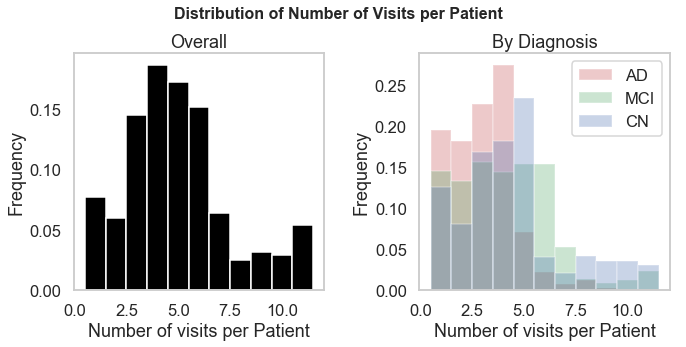

In [55]:
'''HISTOGRAMS OF THE NUMBER OF VISITS PER PATIENT'''

#Get number of visit of each patient (total + separated by diagnosis)
numVisits_overall = df_cdrsb.groupby('ID').agg(['count']).max(axis=1)
numVisits_CN = df_cdrsb.loc[df_cdrsb['Diagnosis']=='CN'].groupby('ID').agg(['count']).max(axis=1)
numVisits_MCI = df_cdrsb.loc[df_cdrsb['Diagnosis']=='MCI'].groupby('ID').agg(['count']).max(axis=1)
numVisits_AD = df_cdrsb.loc[df_cdrsb['Diagnosis']=='AD'].groupby('ID').agg(['count']).max(axis=1)

#Plot histogram
fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5))

fig.suptitle('Distribution of Number of Visits per Patient',fontsize=16,fontweight='bold')

bins = np.arange(1,13,1)

#First axis is the total number of visits by patient
axes[0].hist(numVisits_overall,bins=bins,align='left',color='black',density=True)
axes[0].set_xlabel('Number of visits per Patient')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Overall')
axes[0].grid(False)

#Second axis separates the number of visits by diagnosis
axes[1].hist(numVisits_AD,bins=bins,align='left',color='r',density=True,alpha=0.3)
axes[1].hist(numVisits_MCI,bins=bins,align='left',color='g',density=True,alpha=0.3)
axes[1].hist(numVisits_CN,bins=bins,align='left',color='b',density=True,alpha=0.3)
axes[1].set_xlabel('Number of visits per Patient')
axes[1].set_ylabel('Frequency')
axes[1].set_title('By Diagnosis')
axes[1].grid(False)
leg = axes[1].legend(['AD','MCI','CN'])

plt.tight_layout()
plt.subplots_adjust(top=0.85)

The average number of visit among all patients is $7.3$ and ranges from $1$ to $11$ visits. There is no clear difference between the distributions of number of visits for patient diagnosed with AD, MCI or CN. It is important to verify that our data is Missing Completely at Random (MCAR) rather than Missing at Random (MAR). We cannot verify that the data is not Missing Not at Random (MNAR), since this would required information about the missing points that we do not possess.

Similarly, we can investigate the relation between the number of visits and the CDRSB score. First, we save a new dataframe with the final visit of the patient to get the last CDRSB score.

In [56]:
'''FINAL CDRSB SCORE DF'''

#Group by ID to get patient-specific information and keep last
finalCDRSB_df = df_cdrsb.sort_values(by=['AGE']).groupby('ID').last()
finalDiagnosis_df = df_cdrsb.sort_values(by=['AGE']).groupby('ID').last()

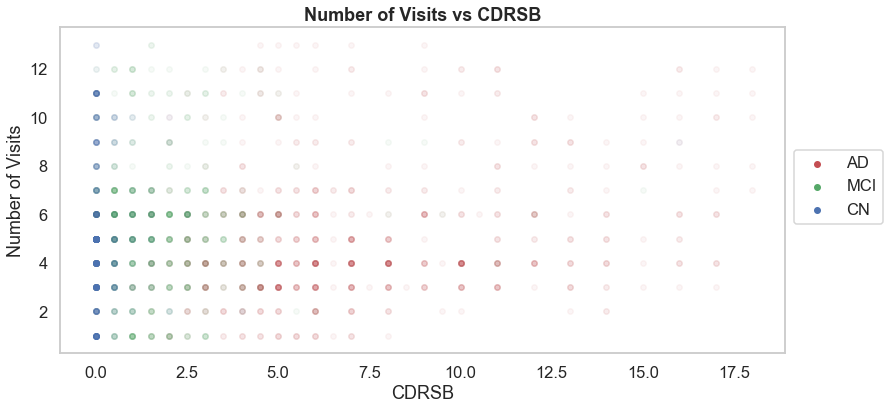

In [57]:
'''NUMBER OF VISITS VS FINAL CDRSB'''

#Get the number of visits by patient and the final CDRSB
numVisits = df_cdrsb.groupby('ID').agg(['count']).max(axis=1)
finalCDRSB_df['Number of Visits'] = numVisits

#Scatter plot with color indicating diagnosis
plt.figure()
ax = plt.gca()

finalCDRSB_df.loc[finalCDRSB_df['Diagnosis']=='AD'].plot('CDRSB','Number of Visits',kind='scatter', alpha=0.05, s=30,color='r',ax=ax)
finalCDRSB_df.loc[finalCDRSB_df['Diagnosis']=='MCI'].plot('CDRSB','Number of Visits',kind='scatter', alpha=0.05, s=30,color='g',ax=ax)
finalCDRSB_df.loc[finalCDRSB_df['Diagnosis']=='CN'].plot('CDRSB','Number of Visits',kind='scatter', alpha=0.05, s=30,color='b',ax=ax)

leg = plt.legend(['AD','MCI','CN'],bbox_to_anchor=(1, 0.65))
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.xlabel('CDRSB')
plt.ylabel('Number of Visits')
plt.title('Number of Visits vs CDRSB',fontweight='bold')
plt.grid(False)

Similar to the distribution of the number of visits by diagnosis, we can conclude from the plot above that there is no clear trend between number of visits, final CDRSB score, and diagnosis. We do not have evidence of missing data of type MAR.

We also need to investigate the missingness in the predictors and across different protocols (ADNI1, ADNIGO, and ADNI2). To visualize this, we can plot the number of observations (not null and not NaN) for each of the predictors separated by protocol.

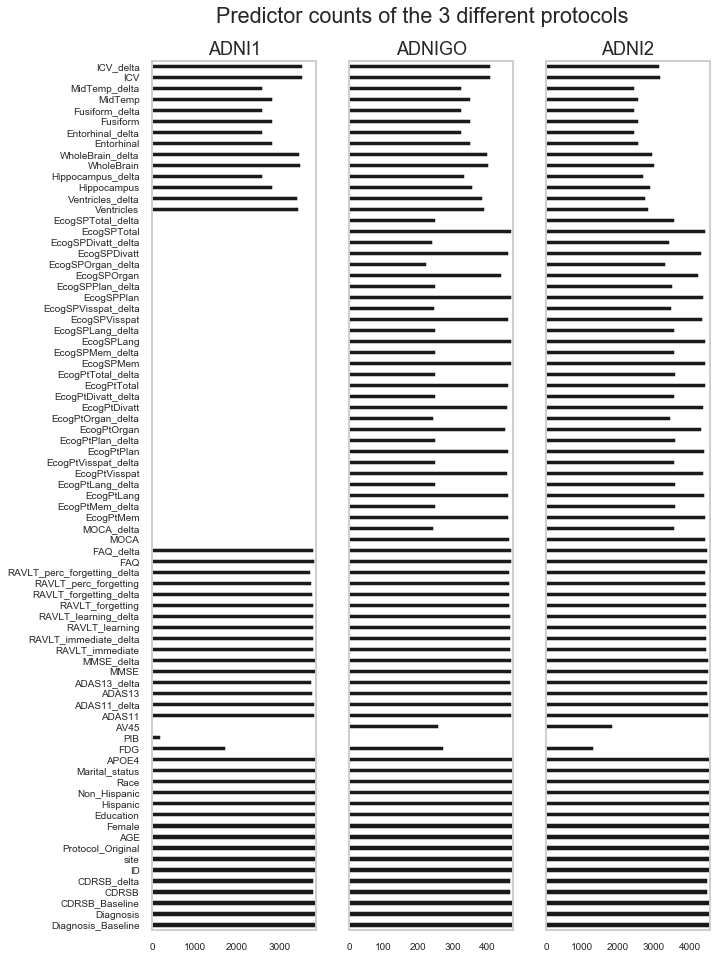

In [58]:
'''MISSING DATA BY PROTOCOL AND PREDICTORS'''

#Horizontal bar plot of the predictor count by protocol (ADNI1, ADNIGO, ADNI2)
fig,axes = plt.subplots(ncols=3,nrows=1,figsize=(10,15),sharey=True)
df_diagnosis.groupby('Protocol').agg('count').loc['ADNI1'].plot.barh(ax=axes[0],color='k')
axes[0].grid(False)
axes[0]
axes[0].set_xlim(0,df_diagnosis.loc[df_diagnosis['Protocol']=='ADNI1'].shape[0])
axes[0].tick_params(labelsize=10)
axes[0].set_title('ADNI1')

df_diagnosis.groupby('Protocol').agg('count').loc['ADNIGO'].plot.barh(ax=axes[1],color='k')
axes[1].set_xlim(0,df_diagnosis.loc[df_diagnosis['Protocol']=='ADNIGO'].shape[0])
axes[1].tick_params(labelsize=10)
axes[1].grid(False)
axes[1].set_title('ADNIGO')

df_diagnosis.groupby('Protocol').agg('count').loc['ADNI2'].plot.barh(ax=axes[2],color='k')
axes[2].set_xlim(0,df_diagnosis.loc[df_diagnosis['Protocol']=='ADNI2'].shape[0])
axes[2].tick_params(labelsize=10)
axes[2].grid(False)
axes[2].set_title('ADNI2')

plt.suptitle('Predictor counts of the 3 different protocols')
plt.subplots_adjust(top=0.93);

Across all protocols, demographic predictors (bottom of the Figure above) and cognitive test predictors (FAQ, RAVLT, etc.) have almost no missing data. In comparison, imaging predictors such as PET scan images AV45, PIB, and FDG as well as brain images (top of Figure above) have a lot of missing data. The Ecog-related predictors (middle of Figure above) only appeared after ADNI1 (and contain many missing $\texttt{delta}$ values ADNIGO and ADNI2). Except for these predictors, all other predictors seem to have similar missing daa among the 3 protocols. 

## Exploration of Response Variables

In this section, we explore our potential response variables: Diagnosis (CN, MCI, AD) and CDRSB. For both of them, we have a value at the baseline (first visit) as well as at subsequent visits. We can first explore the transition between categories from first visit to last visit for each patient.

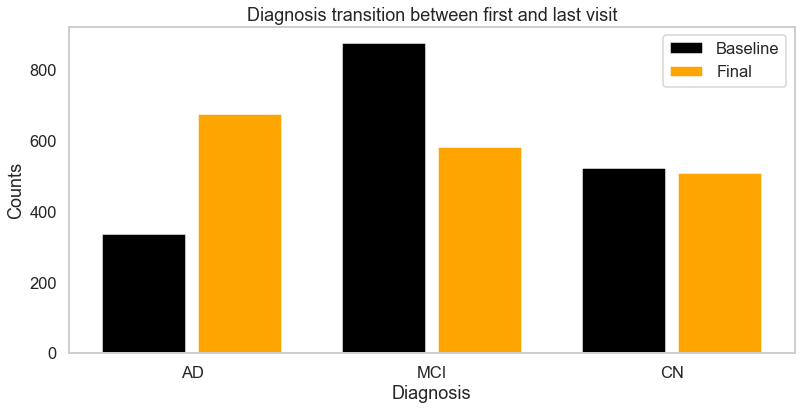

In [59]:
'''BAR PLOT OF DIAGNOSIS TRANSITION'''

#Bar plot of the number of AD, MCI, and CN baseline vs. final
gridnumber = [0,2,1]

plt.bar([g-0.2 for g in gridnumber],finalDiagnosis_df.groupby('Diagnosis_Baseline').size(),label='Baseline',width=0.35,align='center',color='black')
plt.bar([g+0.2 for g in gridnumber],finalDiagnosis_df.groupby('Diagnosis').size(),label='Final',width=0.35,color='orange')
plt.legend()
plt.xlabel('Diagnosis')
plt.ylabel('Counts')
plt.xticks(gridnumber,finalDiagnosis_df.groupby('Diagnosis_Baseline').size().index.values);
plt.grid(False)
plt.title('Diagnosis transition between first and last visit');

The above bar plot does not tell us the migration from one category to the other, but rather the porportions at baseline and final visit. To understand how the categories are changing, we can look at a cross table.

In [60]:
'''CROSS-TABLE OF DIAGNOSIS TRANSITION'''
pd.crosstab(df_diagnosis.Diagnosis_Baseline, df_diagnosis.Diagnosis)

Diagnosis,AD,CN,MCI
Diagnosis_Baseline,,,
AD,1079,0,11
CN,57,2544,210
MCI,972,202,3835


A large proportion of patients diagnosed with CN at baseline stayed CN ($91$\%). For the patients diagnosed with MCI at baseline, about $19$\% of them were diagnosed with AD after the study, $77$\% stayed MCI, and $4$ went back to CN. Finally, for patients diagnosed with AD at baseline, $1$\% of them went back to MCI and no patient went back to CN. This makes sense as AD is non-curable and degenerative.

For the numerical response variable CDRSB, we can explore its progression from the first visit to the last visit. We can plot the final CDRSB score as a function of the baseline CDRSB score color-coded by diagnosis.

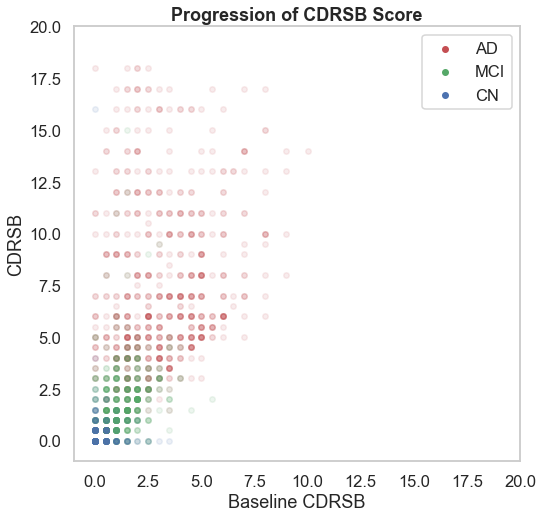

In [61]:
'''PROGRESSION OF CDRSB SCORE'''

#Scatter plot of final CDRSB vs. baseline CDRSB (color is diagnosis) 
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
finalCDRSB_df.loc[finalCDRSB_df['Diagnosis']=='AD'].plot('CDRSB_Baseline','CDRSB', kind='scatter', alpha=0.1, s=30,color='r',ax=ax,label='AD')
finalCDRSB_df.loc[finalCDRSB_df['Diagnosis']=='MCI'].plot('CDRSB_Baseline','CDRSB', kind='scatter', alpha=0.1, s=30,color='g',ax=ax,label='MCI')
finalCDRSB_df.loc[finalCDRSB_df['Diagnosis']=='CN'].plot('CDRSB_Baseline','CDRSB', kind='scatter', alpha=0.1, s=30,color='b',ax=ax,label='CN')
plt.xlabel('Baseline CDRSB')
plt.ylabel('CDRSB')
plt.xlim([-1, 20])
plt.ylim([-1, 20])
plt.title('Progression of CDRSB Score',fontweight='bold')
plt.grid(False)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

We note the following key points:
- Very few people decrease (lower bound of $y=x$) except for low values, where there is more uncertainty in the initial value since the disease presentation is more subtle
- Most people stay the same
- Some people increase dramatically

Finally, a very useful plot is the CDRSB distributions by diagnosis. In the Figure below, the subplots compare a) the baseline CDRSB to the baseline diagnosis, b) the final CDRSB to the final diagnosis, and c) the baseline CDRSB to the final diagnosis.

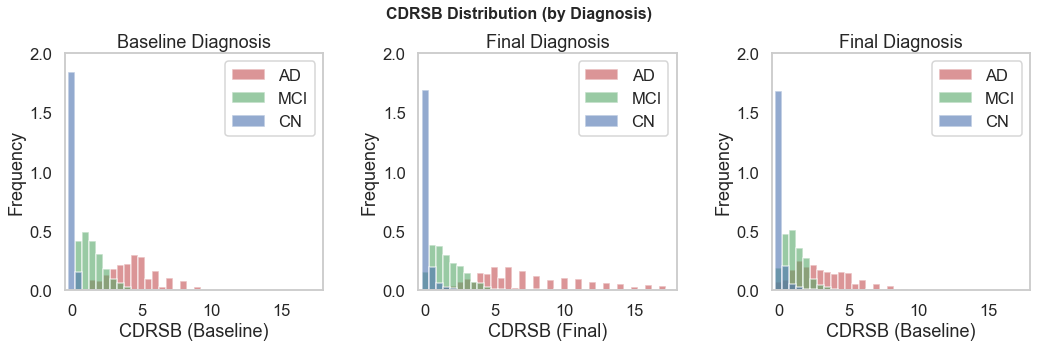

In [62]:
'''CDRSB DISTRIBUTION BY DIAGNOSIS'''

#Histogram of baseline and final CDRSB by initial and final diagnosis
fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize=(15,5))
AD_diagnosis = finalCDRSB_df.groupby('Diagnosis').get_group('AD')['CDRSB']
MCI_diagnosis = finalCDRSB_df.groupby('Diagnosis').get_group('MCI')['CDRSB']
CN_diagnosis = finalCDRSB_df.groupby('Diagnosis').get_group('CN')['CDRSB']

AD_baseline = finalCDRSB_df.groupby('Diagnosis_Baseline').get_group('AD')['CDRSB_Baseline']
MCI_baseline = finalCDRSB_df.groupby('Diagnosis_Baseline').get_group('MCI')['CDRSB_Baseline']
CN_baseline = finalCDRSB_df.groupby('Diagnosis_Baseline').get_group('CN')['CDRSB_Baseline']

AD_comparison = finalCDRSB_df.groupby('Diagnosis').get_group('AD')['CDRSB_Baseline']
MCI_comparison = finalCDRSB_df.groupby('Diagnosis').get_group('MCI')['CDRSB_Baseline']
CN_comparison = finalCDRSB_df.groupby('Diagnosis').get_group('CN')['CDRSB_Baseline']

bins = np.arange(0,18.5,0.5)

axes[0].hist(AD_baseline,alpha=0.6,label='AD',align='left',bins=bins,density=True,color='r')
axes[0].hist(MCI_baseline,alpha=0.6,label='MCI',align='left',bins=bins,density=True,color='g')
axes[0].hist(CN_baseline,alpha=0.6,label='CN',align='left',bins=bins,density=True,color='b')
axes[0].set_ylim(0,2)
axes[0].set_xlim(-0.5,18)
axes[0].set_title('Baseline Diagnosis')
axes[0].set_xlabel('CDRSB (Baseline)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(False)

axes[1].hist(AD_diagnosis,alpha=0.6,label='AD',align='left',bins=bins,density=True,color='r')
axes[1].hist(MCI_diagnosis,alpha=0.6,label='MCI',align='left',bins=bins,density=True,color='g')
axes[1].hist(CN_diagnosis,alpha=0.6,label='CN',align='left',bins=bins,density=True,color='b')
axes[1].set_ylim(0,2)
axes[1].set_xlim(-0.5,18)
axes[1].set_title('Final Diagnosis')
axes[1].set_xlabel('CDRSB (Final)')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(False)

axes[2].hist(AD_comparison,alpha=0.6,label='AD',align='left',bins=bins,density=True,color='r')
axes[2].hist(MCI_comparison,alpha=0.6,label='MCI',align='left',bins=bins,density=True,color='g')
axes[2].hist(CN_comparison,alpha=0.6,label='CN',align='left',bins=bins,density=True,color='b')
axes[2].set_ylim(0,2)
axes[2].set_xlim(-0.5,18)
axes[2].set_title('Final Diagnosis')
axes[2].set_xlabel('CDRSB (Baseline)')
axes[2].set_ylabel('Frequency')
axes[2].legend()
axes[2].grid(False)

plt.tight_layout()
fig.suptitle('CDRSB Distribution (by Diagnosis)',fontsize=16,fontweight='bold')
plt.subplots_adjust(top=0.85)

While the first two plots in the Figure above show that there is a clear difference in the distribution of the CDRSB score with respect to different diagnosis, the third plot could represent a very simple classifier of the final diagnosis based on the initial CDRSB score. The classifier would be:


The above plots could represent a very simple classifier of the diagnosis based on the CDRSB score. The most relevant would be the classification of the final diagnosis based on the initial CDRSB score. The classifier would be:

- CDRSB$_{Baseline} < 0.5$: Final diagnosis is CN
- $0 <$ CDRSB$_{Baseline} < 2.5$: Final diagnosis is MCI
- CDRSB$_{Baseline} \ge 2.5$: Final diagnosis is AD

Based on the final CDRSB score, the classifier would take the form:

- CDRSB$_{Final} \le 0.5$: Final diagnosis is CN
- $0 <$ CDRSB$_{Final} < 4.0$: Final diagnosis is MCI
- CDRSB$_{Final} \ge 4.0$: Final diagnosis is AD


## Exploration of Predictors

Another important part of the EDA is to explore the predictors. We investigated their importance through correlation to CDRSB. Below is a bar plot of the most highly correlated predictors.

In [63]:
'''ONE-HOT ENCODING FOR CORRELATION'''

# Before correlation we one-hot encore the database
df_cdrsb_oneHot = pd.get_dummies(df_cdrsb,drop_first=True)

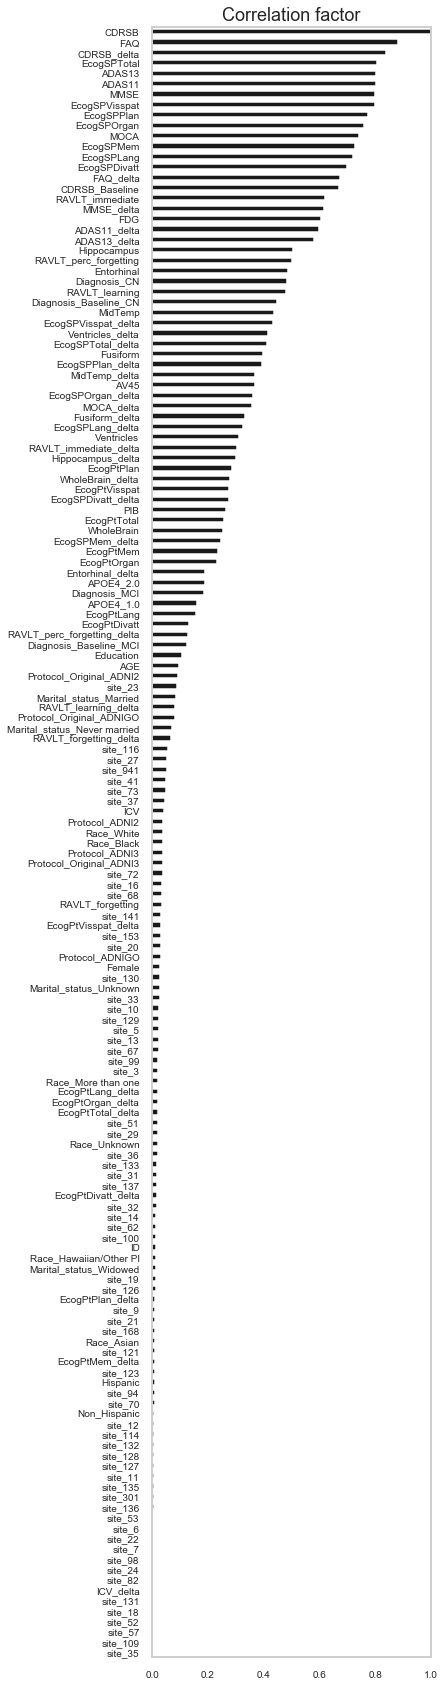

In [64]:
'''PREDICTORS CORRELATION TO CDRSB'''

#Horizontal bar plot of the columns correlation
plt.figure(figsize=(5,30))
correlation = abs(df_cdrsb_oneHot.corr())
CDRSB_corr = correlation['CDRSB'].sort_values(ascending=True)
CDRSB_corr.plot.barh(color='k')
plt.grid(False)
plt.tick_params(labelsize=10)
plt.xlim(0,1);
plt.title('Correlation factor');

The results shown in the bar plot above are promising since a lot of inexpensive cognitive tests such as FAQ, Ecog, ADAS, and MOCA have high correlation to CDRSB. They represent good alternative to more expensive and time consuming imaging data such as FDG and Hippocampus.

## Predicting Current CDRSB Score and Diagnosis

As a first attempt to model the data, we implement models to predict the current diagnosis and CDRSB Score based on a subset of predictors. We perform regression and classification using linear and ensemble models.

### Prepare Data for Training and Testing

For prediction of CDRSB score, we use the cleaned data frame containing the CDRSB score and with diagnosis removed. We also removed the columns where the majorities of the entries are NaNs. To work with sklearn, we one hot encoded all the catagorical data. After the procedures above, we are left with $1687$ entries and $154$ predictors.

In [65]:
'''CDRSB TRAIN AND TEST SETS'''

#One-hot encoding
df_cdrsb_oneHot = pd.get_dummies(df_cdrsb,drop_first=True)
df_cdrsb_oneHot_dropna = df_cdrsb_oneHot.copy()

# Dropping columns that are mostly NaNs. 
df_cdrsb_oneHot_dropna = df_cdrsb_oneHot_dropna.drop(['PIB','AV45','FDG'], axis = 1)

# Dropping all samples with NaN
df_cdrsb_oneHot_dropna = df_cdrsb_oneHot_dropna.dropna()

#Train-test split
y = df_cdrsb_oneHot_dropna['CDRSB'].values
X = df_cdrsb_oneHot_dropna.copy()
X = X.drop(['CDRSB','CDRSB_delta','Diagnosis_CN','Diagnosis_MCI'], axis=1)

X_cdrsb_train, X_cdrsb_test, y_cdrsb_train, y_cdrsb_test = train_test_split(X, y, test_size=0.20, random_state=42)

For prediction of Diagnosis, we use the cleaned data frame containing the diagnosis and with CDRSB score removed. We also removed the columns where the majorities of the entries are NaNs. To work with sklearn, we one hot encoded all the catagorical data. After the procedures above, we are once again left with $1687$ entries and $154$ predictors.

In [66]:
'''DIAGNOSIS TRAIN AND TEST SETS'''

#Copy df
df_diagnosis_dropna = df_diagnosis.copy()

# Dropping columns that are mostly NaNs. 
df_diagnosis_dropna = df_diagnosis_dropna.drop(['PIB', 'AV45','FDG'], axis = 1)

# Dropping all samples with NaN
df_diagnosis_dropna = df_diagnosis_dropna.dropna()

#Train-test split
y = df_diagnosis_dropna['Diagnosis'].values
X = df_diagnosis_dropna.copy()
X = X.drop(['Diagnosis','CDRSB','CDRSB_delta', 'Diagnosis_Baseline'], axis=1)
X = pd.get_dummies(X,drop_first=True) # One Hot Encoding
X_diagnosis_train, X_diagnosis_test, y_diagnosis_train, y_diagnosis_test =\
train_test_split(X, y, test_size=0.20, random_state=42)

### Predict CDRSB with Regression

We explored linear models (linear regression, LASSO, Ridge, Elastic net regularization) as well as ensemble models (decision tree, random forest, bagging, gradient boosting, and adaboost). For regularized models, the hyperparameters were chosen by cross-validation. For the ensemble models, we did not perform hyperparameter tuning at this point in the interest of computational time.

To save the score of each regression model ($R^2$), we implement the following function.

In [67]:
'''SCORING TABLE FUNCTION'''

#Creating a table to compare the results in different models
scores = pd.DataFrame(columns = ['Method','Training score','Test score'])

def add_to_scores(model_name, training_score, test_score): 
    global scores
    scores = scores.append(pd.DataFrame([[model_name,training_score,test_score]], \
                            columns = ['Method','Training score','Test score']))

def get_scores(model,X_train,y_train,X_test,y_test): 
    training_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    return training_score, test_score

In [68]:
'''LINEAR REGRESSION'''
lr = LinearRegression().fit(X_cdrsb_train, y_cdrsb_train)
training_score, test_score = get_scores(lr,X_cdrsb_train,y_cdrsb_train,X_cdrsb_test,y_cdrsb_test)
add_to_scores('LinearRegression', training_score, test_score)

In [69]:
'''RIDGE REGULARIZATION'''
ridge = RidgeCV(cv=5, alphas = [0.001, 0.01, 0.1, 1]).fit(X_cdrsb_train, y_cdrsb_train)
training_score, test_score = get_scores(ridge,X_cdrsb_train,y_cdrsb_train,X_cdrsb_test,y_cdrsb_test)
add_to_scores('RidgeCV', training_score, test_score)

C:\Users\david\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.180568e-17
  overwrite_a=True).T
C:\Users\david\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.067016e-17
  overwrite_a=True).T
C:\Users\david\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.052585e-17
  overwrite_a=True).T
C:\Users\david\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.122328e-17
  overwrite_a=True).T
C:\Users

In [70]:
'''LASSO REGULARIZATION'''
lasso = LassoCV(cv=5, alphas = [0.001, 0.01, 0.1, 1]).fit(X_cdrsb_train, y_cdrsb_train)
training_score, test_score = get_scores(lasso,X_cdrsb_train,y_cdrsb_train,X_cdrsb_test,y_cdrsb_test)
add_to_scores('LassoCV', training_score, test_score)

In [71]:
'''ELASTIC NET'''
en = ElasticNetCV(cv=5, alphas = [0.001, 0.01, 0.1, 1], max_iter=10000).fit(X_cdrsb_train, y_cdrsb_train)
training_score, test_score = get_scores(en,X_cdrsb_train,y_cdrsb_train,X_cdrsb_test,y_cdrsb_test)
add_to_scores('ElasticNetCV', training_score, test_score)

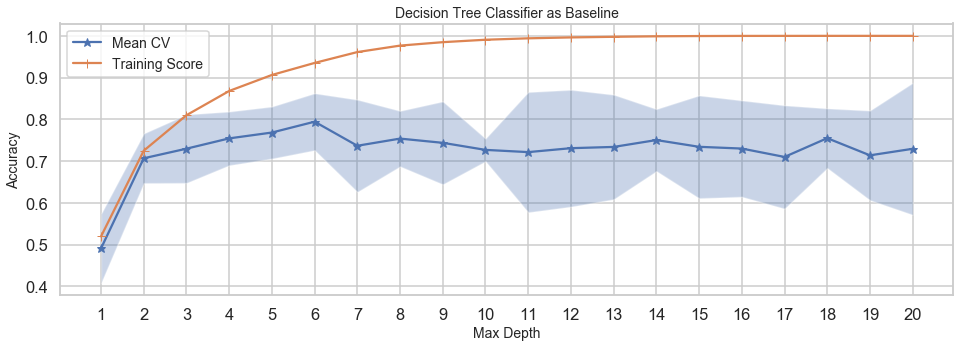

In [72]:
'''DECISION TREE'''

#Explore max depth impact
depths = list(range(1, 21))
train_scores = []
cvmeans = []
cvstds = []
cv_scores = [] 
for d in depths:
    dtree = DecisionTreeRegressor(max_depth=d)
    # Perform 5-fold cross validation and store results 
    train_scores.append(dtree.fit(X_cdrsb_train, y_cdrsb_train).score(X_cdrsb_train, y_cdrsb_train))
    this_score= cross_val_score(estimator=dtree, X=X_cdrsb_train, y=y_cdrsb_train, cv=5)
    cvmeans.append(this_score.mean())
    cvstds.append(this_score.std())
cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)

# plot means and shade the 2 SD interval
plt.figure(figsize=(16,5))
plt.plot(depths, cvmeans, '*-', label="Mean CV")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=
0.3)
ylim = plt.ylim()
plt.plot(depths, train_scores, '-+', label="Training Score")
plt.legend(fontsize=14)
plt.ylabel("Accuracy",fontsize=14)
plt.xlabel("Max Depth",fontsize=14)
plt.xticks(depths);
plt.title('Decision Tree Classifier as Baseline',fontsize=14)
plt.show()

In [73]:
'''BEST DECISION TREE FROM CV'''
best_depth = 5
dt = DecisionTreeRegressor(max_depth=best_depth).fit(X_cdrsb_train, y_cdrsb_train)
training_score, test_score = get_scores(dt,X_cdrsb_train,y_cdrsb_train,X_cdrsb_test,y_cdrsb_test)
add_to_scores('DecisionTreeRegressor', training_score, test_score)

In [74]:
'''ADABOOST'''
ada = AdaBoostRegressor().fit(X_cdrsb_train, y_cdrsb_train)
training_score, test_score = get_scores(ada,X_cdrsb_train,y_cdrsb_train,X_cdrsb_test,y_cdrsb_test)
add_to_scores('AdaBoostRegressor', training_score, test_score)

In [75]:
'''BAGGING'''
bag = BaggingRegressor().fit(X_cdrsb_train, y_cdrsb_train)
training_score, test_score = get_scores(bag,X_cdrsb_train,y_cdrsb_train,X_cdrsb_test,y_cdrsb_test)
add_to_scores('BaggingRegressor', training_score, test_score)

In [76]:
'''GRADIENT BOOSTING'''
gra = GradientBoostingRegressor().fit(X_cdrsb_train, y_cdrsb_train)
training_score, test_score = get_scores(gra,X_cdrsb_train,y_cdrsb_train,X_cdrsb_test,y_cdrsb_test)
add_to_scores('GradientBoostingRegressor', training_score, test_score)

In [77]:
'''RANDOM FOREST'''
rf = RandomForestRegressor().fit(X_cdrsb_train, y_cdrsb_train)
training_score, test_score = get_scores(rf,X_cdrsb_train,y_cdrsb_train,X_cdrsb_test,y_cdrsb_test)
add_to_scores('RandomForestRegressor', training_score, test_score)

In [78]:
scores.head(20)

,Method,Training score,Test score
0,LinearRegression,0.885915,0.857309
0,RidgeCV,0.885272,0.859498
0,LassoCV,0.872684,0.864085
0,ElasticNetCV,0.875634,0.862735
0,DecisionTreeRegressor,0.906364,0.825381
0,AdaBoostRegressor,0.768270,0.726817
0,BaggingRegressor,0.974780,0.879723
0,GradientBoostingRegressor,0.958440,0.875221
0,RandomForestRegressor,0.978864,0.877697


Table above shows that we can have highly perfomant models predicting the current CDRSB score. We can easily explain above $87$\% of the variance with Random Forest ($87.0$\%), Gradient Boosting ($88.1$\%), and Bagging ($90.0$\%).

### Predict Diagnosis with Classification

We explored the following classifiers with no hyperparameter tuning: logistic regression, random forest, baggging,
gradient boosting, and adaboost.

To save the score of each regression model (accuracy), we implement the following function.

In [79]:
'''SCORING TABLE FUNCTION'''

#Creating a table to compare the results in different models
scores_diag = pd.DataFrame(columns = ['Method','Training accuracy','Test accuracy'])

def add_to_diag_scores(model_name, training_score, test_score): 
    global scores_diag
    scores_diag = scores_diag.append(pd.DataFrame([[model_name,training_score,test_score]], \
                            columns = ['Method','Training accuracy','Test accuracy']))
def get_acc_scores(model,X_train,y_train,X_test,y_test): 
    training_score = accuracy_score(y_train, model.predict(X_train))
    test_score = accuracy_score(y_test, model.predict(X_test))
    return training_score, test_score

In [80]:
'''LOGISTIC REGRESSION'''
log = LogisticRegression().fit(X_diagnosis_train, y_diagnosis_train)
training_score, test_score = get_acc_scores(log,X_diagnosis_train, y_diagnosis_train,X_diagnosis_test, y_diagnosis_test)
add_to_diag_scores('LogisticRegression', training_score, test_score)

In [81]:
'''ADABOOST'''
model = AdaBoostClassifier().fit(X_diagnosis_train, y_diagnosis_train)
training_score, test_score = get_acc_scores(model,X_diagnosis_train, y_diagnosis_train,X_diagnosis_test, y_diagnosis_test)
add_to_diag_scores('AdaBoostClassifier', training_score, test_score)

In [82]:
'''BAGGING'''
model = BaggingClassifier().fit(X_diagnosis_train, y_diagnosis_train)
training_score, test_score = get_acc_scores(model,X_diagnosis_train, y_diagnosis_train,X_diagnosis_test, y_diagnosis_test)
add_to_diag_scores('BaggingClassifier', training_score, test_score)

In [83]:
'''GRADIENT BOOSTING'''
model = GradientBoostingClassifier().fit(X_diagnosis_train, y_diagnosis_train)
training_score, test_score = get_acc_scores(model,X_diagnosis_train, y_diagnosis_train,X_diagnosis_test, y_diagnosis_test)
add_to_diag_scores('GradientBoostingClassifier', training_score, test_score)

In [84]:
'''RANDOM FOREST'''
model = RandomForestClassifier().fit(X_diagnosis_train, y_diagnosis_train)
training_score, test_score = get_acc_scores(model,X_diagnosis_train, y_diagnosis_train,X_diagnosis_test, y_diagnosis_test)
add_to_diag_scores('RandomForestClassifier', training_score, test_score)

In [85]:
scores_diag.head(20)

,Method,Training accuracy,Test accuracy
0,LogisticRegression,0.627890,0.633929
0,AdaBoostClassifier,0.808352,0.809524
0,BaggingClassifier,0.991797,0.892857
0,GradientBoostingClassifier,0.995526,0.916667
0,RandomForestClassifier,0.992543,0.889881


Similar to the regression on the current CDRSB score, with Bagging, Gradient Boosting, and Random Forest, we can predict the current diagnosis with an accuracy above $88$\%.

It seems we can acheive high performance when predicting current response variables. In the following sections, we will highlight the increased level of difficulty associated with the prediction of future data.